In [ ]:
import torch
torch.cuda.set_device('cuda:0')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch

# import torchsummary
import torchvision as tv
from torchvision import transforms, datasets
from torchvision.transforms import v2

from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

from torch.distributions.normal import Normal
import torch.nn.functional as F

In [ ]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))  # print the name of the GPU
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB") # print the memory allocated
    print(f"Memory Cached: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB") # print the memory cached


Quadro RTX 5000
Memory Allocated: 0.00 MB
Memory Cached: 0.00 MB


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Disclaimer I have used chatgpt to help me generate the code because at this stage i know the concepts and i am familiar to pytorch 
# but not at an extent that i can write the code from scratch. I have used the code generated by chatgpt and modified it to suit my needs.

# the models are based on the architecture defined in the paper.


#########################################
# 1. MNIST FEED-FORWARD VAE
#########################################

class MNISTEncoder(nn.Module): # define encoder subclass
    def __init__(self, latent_dim=1024): # initialize the class and ask for latent dimension
        super(MNISTEncoder, self).__init__() # initialize the parent class
        # images are scaled to [0,1] 
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        
        # Final layer produces 2*latent_dim outputs (to split into μ and pre-σ)a
        self.fc4 = nn.Linear(1024, latent_dim * 2)
    
    def forward(self, x):
        # Flatten the image: [batch, 1, 28, 28] -> [batch, 784]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        # Split the output in half for μ and logσ
        mu, log_sigma = torch.chunk(x, 2, dim=1)
        # Use softplus to ensure σ > 0
        sigma = F.softplus(log_sigma)
        return mu, sigma

class MNISTDecoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super(MNISTDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        # Final layer produces 28*28 outputs
        self.fc4 = nn.Linear(1024, 28 * 28)
    
    def forward(self, z):
        x = F.relu(self.fc1(z))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # Sigmoid activation to map to [0,1]
        x = torch.sigmoid(self.fc4(x))
        x = x.view(-1, 1, 28, 28)
        return x

class MNISTVAE(nn.Module):
    def __init__(self, latent_dim=1024):
        super(MNISTVAE, self).__init__()
        self.encoder = MNISTEncoder(latent_dim)
        self.decoder = MNISTDecoder(latent_dim)
    
    def reparameterize(self, mu, sigma):
        eps = torch.randn_like(sigma)
        return mu + eps * sigma
        # mu is 1x1 scalar and sigma is 1xlatent_dim we fist generate a random tensor of the same shape as sigma
        # then we multiply it with sigma and add mu to get the reparameterized value
    def forward(self, x):
        mu, sigma = self.encoder(x)
        z = self.reparameterize(mu, sigma)
        x_recon = self.decoder(z)
        return x_recon, mu, sigma

#########################################
# 2. CELEBA CONVOLUTIONAL VAE
#########################################

class CelebAEncoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super(CelebAEncoder, self).__init__()
        # We use padding so that each conv roughly halves the spatial dimensions.
        self.conv1 = nn.Conv2d(3, 2048, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(2048, 1024, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(1024, 512, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(512, 256, kernel_size=5, stride=2, padding=2)
        # After four conv layers, for a 64x64 input, the feature map becomes 4x4.
        self.fc = nn.Linear(256 * 4 * 4, 2048)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        mu, log_sigma = torch.chunk(x, 2, dim=1)
        sigma = F.softplus(log_sigma)
        return mu, sigma

class CelebADecoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super(CelebADecoder, self).__init__()
        # Linear layer to transform z into a “seed” feature map of size 4x4x2048
        self.fc = nn.Linear(latent_dim, 2048 * 4 * 4)
        # Transposed conv layers (all but the last with ReLU)
        self.deconv1 = nn.ConvTranspose2d(2048, 1024, kernel_size=5, stride=2,
                                          padding=2, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2,
                                          padding=2, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2,
                                          padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(256, 3, kernel_size=3, stride=2,
                                          padding=1, output_padding=1)
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 2048, 4, 4)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.sigmoid(self.deconv4(x))
        return x

class CelebAVAE(nn.Module):
    def __init__(self, latent_dim=1024):
        super(CelebAVAE, self).__init__()
        self.encoder = CelebAEncoder(latent_dim)
        self.decoder = CelebADecoder(latent_dim)
    
    def reparameterize(self, mu, sigma):
        eps = torch.randn_like(sigma)
        return mu + eps * sigma
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        z = self.reparameterize(mu, sigma)
        x_recon = self.decoder(z)
        return x_recon, mu, sigma

#########################################
# 3. MELODY SEQUENCE VAE (Hierarchical)
#########################################

# Encoder: Uses a bidirectional LSTM to process a melody (sequence of tokens).
class MelodyEncoder(nn.Module):
    def __init__(self, vocab_size=130, embed_dim=128, latent_dim=512):
        super(MelodyEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # Single-layer bidirectional LSTM with 2048 units per direction.
        self.lstm = nn.LSTM(embed_dim, hidden_size=2048, bidirectional=True, batch_first=True)
        # Linear layer to map concatenated final hidden states (2*2048) to 1024 outputs.
        self.fc = nn.Linear(2 * 2048, 1024)
        self.latent_dim = latent_dim
    
    def forward(self, x):
        # x: [batch, seq_len] (seq_len = 256)
        x_embed = self.embedding(x)  # [batch, seq_len, embed_dim]
        output, (h_n, c_n) = self.lstm(x_embed)
        # h_n has shape [num_directions, batch, hidden_size]
        h_forward = h_n[0]
        h_backward = h_n[1]
        h = torch.cat([h_forward, h_backward], dim=1)  # [batch, 4096]
        h = self.fc(h)  # [batch, 1024]
        mu, log_sigma = torch.chunk(h, 2, dim=1)  # each [batch, 512]
        sigma = F.softplus(log_sigma)
        return mu, sigma

# Decoder: A hierarchical decoder that first generates “bar embeddings” then generates note events.
class MelodyDecoder(nn.Module):
    def __init__(self, vocab_size=130, embed_dim=128, latent_dim=512,
                 hidden_dim=1024, num_bars=16, notes_per_bar=16):
        super(MelodyDecoder, self).__init__()
        self.num_bars = num_bars
        self.notes_per_bar = notes_per_bar
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        
        # Bar-level LSTM (2 layers). We “seed” it with a transformation of z.
        self.bar_init_fc = nn.Linear(latent_dim, 2 * hidden_dim)
        # For the bar LSTM we provide a fixed dummy input sequence.
        self.bar_input_fc = nn.Linear(1, hidden_dim)
        self.bar_lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim,
                                num_layers=2, batch_first=True)
        # Convert bar LSTM outputs to bar embeddings (size 512)
        self.bar_embedding_fc = nn.Linear(hidden_dim, 512)
        
        # Note-level LSTM (2 layers). It receives at each time step the concatenation of the current bar embedding
        # and the embedding of the previous note.
        self.note_lstm = nn.LSTM(input_size=512 + embed_dim, hidden_size=hidden_dim,
                                 num_layers=2, batch_first=True)
        # Use the bar embedding to initialize the note-level LSTM (both hidden and cell states)
        self.note_init_fc = nn.Linear(512, 2 * hidden_dim)
        # Linear layer to produce logits over the vocabulary (130 classes)
        self.note_fc = nn.Linear(hidden_dim, vocab_size)
        
        # Embedding layer for note tokens (for teacher forcing)
        self.note_embedding = nn.Embedding(vocab_size, embed_dim)
        # A learned start token (embedding) used as the first input to the note-level LSTM.
        self.start_token = nn.Parameter(torch.zeros(embed_dim))
    
    def forward(self, z, target_seq=None, teacher_forcing_ratio=0.5):
        """
        Args:
            z: latent vector [batch, latent_dim]
            target_seq: ground-truth melody tokens with shape [batch, num_bars, notes_per_bar] (optional)
            teacher_forcing_ratio: probability to use ground-truth at each time step.
        Returns:
            output sequence: logits with shape [batch, num_bars * notes_per_bar, vocab_size]
        """
        batch_size = z.size(0)
        device = z.device

        # ----- Bar-Level Generation -----
        # Initialize bar-level LSTM hidden state from z.
        init_state = torch.tanh(self.bar_init_fc(z))  # [batch, 2*hidden_dim]
        h0_bar = init_state.unsqueeze(0).repeat(2, 1, 1)  # [num_layers, batch, hidden_dim]
        c0_bar = torch.zeros_like(h0_bar)
        
        # Dummy input for bar-level LSTM: a constant tensor of ones.
        bar_inputs = torch.ones(batch_size, self.num_bars, 1, device=device)
        bar_inputs = self.bar_input_fc(bar_inputs)  # [batch, num_bars, hidden_dim]
        bar_outputs, _ = self.bar_lstm(bar_inputs, (h0_bar, c0_bar))  # [batch, num_bars, hidden_dim]
        # Convert to bar embeddings.
        bar_embeddings = self.bar_embedding_fc(bar_outputs)  # [batch, num_bars, 512]

        # ----- Note-Level Generation -----
        all_notes = []
        for i in range(self.num_bars):
            # Get the bar embedding for the current bar.
            bar_embed = bar_embeddings[:, i, :]  # [batch, 512]
            # Initialize note-level LSTM hidden state from bar embedding.
            init_note = torch.tanh(self.note_init_fc(bar_embed))  # [batch, 2*hidden_dim]
            h0_note = init_note.unsqueeze(0).repeat(2, 1, 1)  # [num_layers, batch, hidden_dim]
            c0_note = torch.zeros_like(h0_note)
            
            note_outputs = []
            # For the first time step, use the learned start token.
            input_token = self.start_token.unsqueeze(0).expand(batch_size, -1)  # [batch, embed_dim]
            hidden = (h0_note, c0_note)
            for t in range(self.notes_per_bar):
                # At each step, concatenate the (constant) bar embedding with the previous token embedding.
                lstm_input = torch.cat([bar_embed, input_token], dim=1).unsqueeze(1)  # [batch, 1, 512+embed_dim]
                out, hidden = self.note_lstm(lstm_input, hidden)  # out: [batch, 1, hidden_dim]
                logits = self.note_fc(out.squeeze(1))  # [batch, vocab_size]
                note_outputs.append(logits.unsqueeze(1))  # collect logits
                
                # Decide next input token: if ground-truth provided, use teacher forcing.
                if target_seq is not None:
                    # target_seq for the current bar: shape [batch, notes_per_bar]
                    teacher_token = target_seq[:, i, t]  # [batch]
                    use_teacher = (torch.rand(batch_size, device=device) < teacher_forcing_ratio)
                    predicted_token = logits.argmax(dim=1)
                    next_token = torch.where(use_teacher, teacher_token, predicted_token)
                else:
                    next_token = logits.argmax(dim=1)
                input_token = self.note_embedding(next_token)
            # note_outputs for this bar: [batch, notes_per_bar, vocab_size]
            note_outputs = torch.cat(note_outputs, dim=1)
            all_notes.append(note_outputs.unsqueeze(1))  # add a bar dimension

        # Concatenate all bar outputs: [batch, num_bars, notes_per_bar, vocab_size]
        all_notes = torch.cat(all_notes, dim=1)
        # Reshape to a flat sequence: [batch, num_bars * notes_per_bar, vocab_size]
        all_notes = all_notes.view(batch_size, self.num_bars * self.notes_per_bar, -1)
        return all_notes

class MelodyVAE(nn.Module):
    def __init__(self, vocab_size=130, embed_dim=128, latent_dim=512,
                 hidden_dim=1024, num_bars=16, notes_per_bar=16):
        super(MelodyVAE, self).__init__()
        self.encoder = MelodyEncoder(vocab_size, embed_dim, latent_dim)
        self.decoder = MelodyDecoder(vocab_size, embed_dim, latent_dim,
                                     hidden_dim, num_bars, notes_per_bar)
    
    def reparameterize(self, mu, sigma):
        eps = torch.randn_like(sigma)
        return mu + eps * sigma
    
    def forward(self, x, target_seq=None, teacher_forcing_ratio=0.5):
        """
        Args:
            x: input melody tokens [batch, seq_len] (seq_len = 256)
            target_seq: ground-truth melody tokens organized as [batch, num_bars, notes_per_bar]
        Returns:
            output sequence logits, mu, sigma
        """
        mu, sigma = self.encoder(x)
        z = self.reparameterize(mu, sigma)
        output_seq = self.decoder(z, target_seq, teacher_forcing_ratio)
        return output_seq, mu, sigma

#########################################
# 4. ACTOR FEED-FORWARD NETWORK (G(z))
#########################################
#########################################
# EXAMPLE: Checking the Selected Device
#########################################

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    # Example: instantiate the MNIST VAE and forward a dummy batch.
    mnist_vae = MNISTVAE(latent_dim=1024).to(device)
    dummy_mnist = torch.randn(16, 1, 28, 28).to(device)  # batch of 16
    recon, mu, sigma = mnist_vae(dummy_mnist)
    print("MNIST VAE reconstruction shape:", recon.shape)
    
    # Similarly, instantiate and test other modules as needed.


Using device: cuda
MNIST VAE reconstruction shape: torch.Size([16, 1, 28, 28])


# Training VAE on celebA

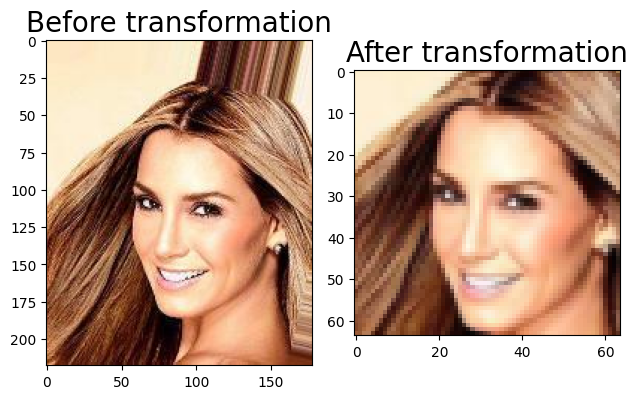

In [4]:


def create_filepaths():
    filenames = pd.read_csv('./data/list_eval_partition.csv')

    train_filenames = filenames[filenames['partition'] == 0]['image_id'].values
    val_filenames = filenames[filenames['partition'] == 1]['image_id'].values

    path_to_files = './data/img_align_celeba/img_align_celeba/'
    train_filepaths = path_to_files + train_filenames
    val_filepaths = path_to_files+val_filenames
    
    return train_filepaths, val_filepaths

def create_filepaths_all():
    filenames = pd.read_csv('./data/list_eval_partition.csv')

    imagename = filenames['image_id'].values
    # val_filenames = filenames[filenames['partition'] == 1]['image_id'].values

    path_to_files = './data/img_align_celeba/img_align_celeba/'
    # train_filepaths = path_to_files + train_filenames
    # val_filepaths = path_to_files+val_filenames
    
    filepaths = path_to_files + imagename
    
    return filepaths




# train_filepaths, val_filepaths = create_filepaths()

all_paths = create_filepaths_all()


def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images[0].detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break



INPUT_SHAPE=(3,64,64)

class CreateDataset(Dataset):
    def __init__(self, imgs):
        self.imgs = [img for img in imgs if self.is_valid(img)]
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        image = self.imgs[index]
        X = self.transform(image)
        return X, X
        
    def transform(self, path):
        img = tv.io.read_image(path)
        img = transforms.v2.functional.resized_crop(img, 40, 15, 148, 148, INPUT_SHAPE[1:], transforms.InterpolationMode.BILINEAR, True)/255.
        return img
    
    def is_valid(self, path):
        img = tv.io.read_image(path)
        return (img.shape[1] >= INPUT_SHAPE[1]) and (img.shape[2] >= INPUT_SHAPE[2])





# train_dataset = CreateDataset(train_filepaths)
# val_dataset = CreateDataset(val_filepaths)
dataset = CreateDataset(all_paths)

# train_dl = DataLoader(train_dataset, 32, shuffle=True, pin_memory=True, num_workers=2) #num_workers=3
# val_dl = DataLoader(val_dataset, 32, shuffle=True, pin_memory=True, num_workers=2)
dataloader = DataLoader(dataset, 32, shuffle=True, pin_memory=True, num_workers=2)


fig,axes = plt.subplots(1,2)
axes[0].imshow(tv.io.read_image(all_paths[0]).permute(1, 2, 0))
axes[0].set_title('Before transformation',fontsize=20)
axes[1].imshow(dataset.transform(all_paths[0]).permute(1,2,0))

axes[1].set_title('After transformation',fontsize=20)
plt.tight_layout()
plt.show()

# plt.figure()
# show_batch(train_dl, 32)
# plt.savefig("./images/batch.jpg", bbox_inches='tight')
# plt.close()



In [4]:
for i in train_dl:
    print(i)
    break

[tensor([[[[0.9373, 0.9255, 0.9333,  ..., 0.6549, 0.7020, 0.6314],
          [0.9255, 0.9059, 0.8706,  ..., 0.6667, 0.6431, 0.6941],
          [0.8667, 0.8314, 0.7490,  ..., 0.5725, 0.6000, 0.5647],
          ...,
          [0.8039, 0.8745, 0.9647,  ..., 0.2039, 0.2980, 0.2980],
          [0.8706, 0.9451, 0.9451,  ..., 0.2118, 0.2902, 0.3451],
          [0.9647, 0.9529, 0.9412,  ..., 0.2235, 0.2784, 0.3569]],

         [[0.8353, 0.8275, 0.8235,  ..., 0.5725, 0.6235, 0.5490],
          [0.8078, 0.7882, 0.7490,  ..., 0.5804, 0.5569, 0.6118],
          [0.7333, 0.6941, 0.6196,  ..., 0.4706, 0.5059, 0.4784],
          ...,
          [0.7882, 0.8549, 0.9490,  ..., 0.1333, 0.1961, 0.1725],
          [0.8588, 0.9529, 0.9373,  ..., 0.1412, 0.1843, 0.2039],
          [0.9451, 0.9725, 0.9373,  ..., 0.1529, 0.1725, 0.2078]],

         [[0.6471, 0.6235, 0.6118,  ..., 0.3765, 0.4235, 0.3529],
          [0.6157, 0.5882, 0.5373,  ..., 0.3843, 0.3608, 0.4157],
          [0.5451, 0.4980, 0.4157,  ..., 

In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

#########################################
# CelebA Convolutional VAE Components
#########################################

class CelebAEncoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super(CelebAEncoder, self).__init__()
        # Four 2D convolutional layers.
        self.conv1 = nn.Conv2d(3, 2048, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(2048, 1024, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(1024, 512, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(512, 256, kernel_size=5, stride=2, padding=2)
        # For a 64×64 input, after 4 conv layers the feature map becomes 4×4.
        self.fc = nn.Linear(256 * 4 * 4, 2048)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))   # [B, 2048, 32, 32]
        x = F.relu(self.conv2(x))   # [B, 1024, 16, 16]
        x = F.relu(self.conv3(x))   # [B, 512, 8, 8]
        x = F.relu(self.conv4(x))   # [B, 256, 4, 4]
        x = x.view(x.size(0), -1)     # Flatten
        x = self.fc(x)              # [B, 2048]
        # Split into two halves: one for μ and one for log-σ (pre-softplus)
        mu, log_sigma = torch.chunk(x, 2, dim=1)
        # Ensure σ > 0 using softplus.
        sigma = F.softplus(log_sigma)
        return mu, sigma

class CelebADecoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super(CelebADecoder, self).__init__()
        # Transform the latent vector into a seed feature map.
        self.fc = nn.Linear(latent_dim, 2048 * 4 * 4)
        # Four transposed convolutional layers.
        self.deconv1 = nn.ConvTranspose2d(2048, 1024, kernel_size=5, stride=2,
                                          padding=2, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2,
                                          padding=2, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2,
                                          padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(256, 3, kernel_size=3, stride=2,
                                          padding=1, output_padding=1)
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 2048, 4, 4)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        # Use sigmoid to map the output to [0, 1].
        x = torch.sigmoid(self.deconv4(x))
        return x

class CelebAVAE(nn.Module):
    def __init__(self, latent_dim=1024):
        super(CelebAVAE, self).__init__()
        self.encoder = CelebAEncoder(latent_dim)
        self.decoder = CelebADecoder(latent_dim)
    
    def reparameterize(self, mu, sigma):
        eps = torch.randn_like(sigma)
        return mu + eps * sigma
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        z = self.reparameterize(mu, sigma)
        recon = self.decoder(z)
        return recon, mu, sigma

#########################################
# Loss Function for the VAE
#########################################

def loss_function(recon_x, x, mu, sigma):
    # Reconstruction loss (BCE) summed over all pixels.
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence between the approximate posterior and the unit Gaussian.
    KL = -0.5 * torch.sum(1 + 2 * torch.log(sigma) - mu.pow(2) - sigma.pow(2))
    return BCE + KL

#########################################
# Training the CelebA VAE
#########################################


# # Hyperparameters
# batch_size = 64
# epochs = 20
# latent_dim = 1024
# learning_rate = 3e-4
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # # Data transforms: center-crop to 128×128, then resize to 64×64.
# # transform = transforms.Compose([
# #     transforms.CenterCrop(128),
# #     transforms.Resize((64, 64)),
# #     transforms.ToTensor(),  # Scales images to [0,1]
# # ])

# # # Load the CelebA training split (download if needed).
# # dataset = datasets.CelebA(root='./data3', split='train', download=False, transform=transform)
# # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# # Initialize model and optimizer.
# model = CelebAVAE(latent_dim=latent_dim).to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# model.train()
# for epoch in range(1, epochs + 1):
#     train_loss = 0
#     for batch_idx, (data, _) in enumerate(dataloader):
#         data = data.to(device)
#         optimizer.zero_grad()
#         recon, mu, sigma = model(data)
#         loss = loss_function(recon, data, mu, sigma)
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()
        
#         if batch_idx % 100 == 0:
#             avg_batch_loss = loss.item() / data.size(0)
#             print(f"Epoch [{epoch}/{epochs}] Batch [{batch_idx}/{len(dataloader)}] Loss: {avg_batch_loss:.4f}")
    
#     avg_loss = train_loss / len(dataset)
#     print(f"====> Epoch: {epoch} Average loss: {avg_loss:.4f}")
    
#     # Optionally, save a grid of reconstructed images for visual monitoring.
#     with torch.no_grad():
#         sample_batch = next(iter(dataloader))[0].to(device)
#         recon_sample, _, _ = model(sample_batch)
#         grid = utils.make_grid(recon_sample[:16], nrow=4)
#         os.makedirs('results', exist_ok=True)
#         utils.save_image(grid, f"results/epoch_{epoch}.png")

#     # Save the model checkpoint.
#     torch.save(model.state_dict(), "celeba_vae.pth")
# print("Training finished and model saved.")

/tmp/ipykernel_2271040/745101618.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('celeba_vae.pth', map_location=device))


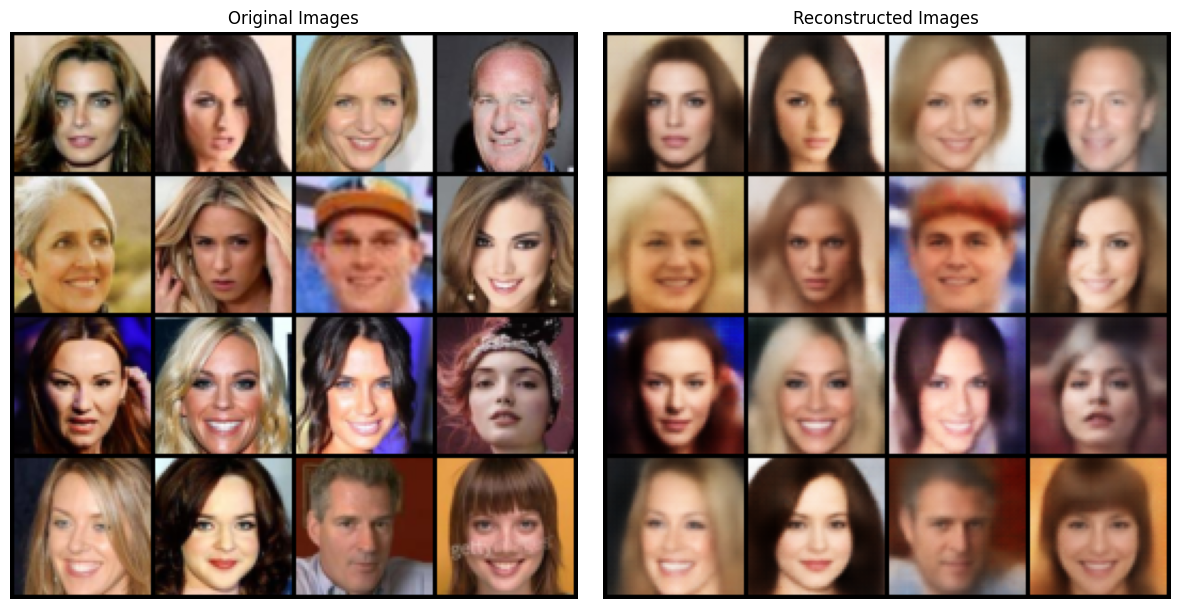

In [6]:
import torch
import os
import torchvision.utils as utils
import matplotlib.pyplot as plt

# Assume that 'dataloader', 'device', and 'epoch' are defined elsewhere.
# Initialize and load the model.
model = CelebAVAE().to(device)
model.load_state_dict(torch.load('celeba_vae.pth', map_location=device))

with torch.no_grad():
    # Retrieve a sample batch from the dataloader.
    # If your dataloader returns a tuple (e.g., (images, labels)),
    # we select the images by indexing [0].
    sample_batch = next(iter(dataloader))[0].to(device)
    
    # Pass the sample batch through the model to obtain reconstructions.
    # Adjust the unpacking if your model returns additional outputs.
    recon_sample, _, _ = model(sample_batch)
    
    # Create grids for the first 16 images in both original and reconstructed batches.
    original_grid = utils.make_grid(sample_batch[:16], nrow=4, padding=2, normalize=True)
    recon_grid = utils.make_grid(recon_sample[:16], nrow=4, padding=2, normalize=True)

# Plot the original and reconstructed images side by side using Matplotlib.
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display original images.
axes[0].imshow(original_grid.permute(1, 2, 0).cpu().numpy())
axes[0].set_title("Original Images")
axes[0].axis('off')

# Display reconstructed images.
axes[1].imshow(recon_grid.permute(1, 2, 0).cpu().numpy())
axes[1].set_title("Reconstructed Images")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Optionally, save the combined figure.
os.makedirs('results', exist_ok=True)
fig.savefig(f"results/epoch_.png")


/tmp/ipykernel_2271040/3240955117.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('celeba_vae.pth', map_location=device))


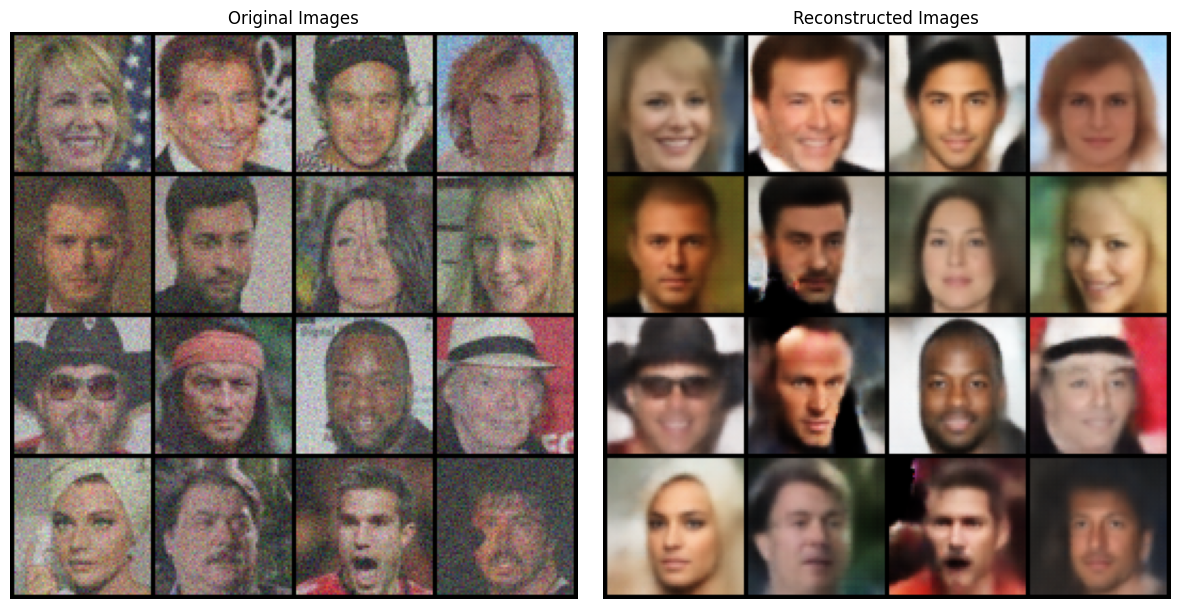

In [ ]:
import torch
import os
import torchvision.utils as utils
import matplotlib.pyplot as plt

# Assume that 'dataloader', 'device', and 'epoch' are defined elsewhere.
# Initialize and load the model.
model = CelebAVAE().to(device)
model.load_state_dict(torch.load('celeba_vae.pth', map_location=device))

with torch.no_grad():
    sample_batch = next(iter(dataloader))[0].to(device) + 0.1 * torch.randn(32, 3, 64, 64).to(device)
    recon_sample, _, _ = model(sample_batch)
    original_grid = utils.make_grid(sample_batch[:16], nrow=4, padding=2, normalize=True)
    recon_grid = utils.make_grid(recon_sample[:16], nrow=4, padding=2, normalize=True)

# Plot the original and reconstructed images side by side using Matplotlib.
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display original images.
axes[0].imshow(original_grid.permute(1, 2, 0).cpu().numpy())
axes[0].set_title("Original Images")
axes[0].axis('off')

# Display reconstructed images.
axes[1].imshow(recon_grid.permute(1, 2, 0).cpu().numpy())
axes[1].set_title("Reconstructed Images")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Optionally, save the combined figure.
os.makedirs('results', exist_ok=True)
fig.savefig(f"results/epoch_.png")
